
### Evaluation of the effects and the feasibility of stratospheric sulfate aerosol injection using a grey atmosphere model for Earth - RCP 2.6 scenario

**Step 1: model the current state of climate with a 2-layer grey atmosphere model, in equilibrium**

Determine the emissivity for the lower layer (i.e. the troposphere) to match the current average surface temperature (288.15K).
To do so, we assume a low emissivity (0.01) for the upper layer (i.e. the stratosphere), as most of the greenhouse gases are concentrated in the troposphere.
Also, we introduce an additional albedo for the upper layer, which will be changed later in the project to model the injection of sulfate aerosols in the stratosphere.

In [1]:
import numpy as np
import sympy as s
import matplotlib
import matplotlib.pyplot as plt
% matplotlib inline 
import sympy as s
s.init_printing()

# Equations for the 2-layer grey atmosphere
#alpha,S0,sigma,B1,Bs,B2,e1,e2 = s.symbols('alpha S_0 sigma B_1 B_s B_2 epsilon_1  epsilon_2')
alpha,alpha2,S0,sigma,Bs,B1,B2,e1,e2 = s.symbols('alpha,alpha2,S_0,sigma,B_s,B_1,B_2,epsilon_1,epsilon_2')

# Surface
L0 = s.Eq((1-alpha2)*S0/4 + e1*B1 + (1-e1)*e2*B2, alpha*(1-alpha2)*S0/4 + Bs)
# Bottom layer - troposphere
L1 = s.Eq(e1*Bs+e1*e2*B2, 2*e1*B1)
# Top layer - stratosphere
L2 = s.Eq((1-e1)*e2*Bs+e1*e2*B1,2*e2*B2)

# Solve the model
ans = s.solve([L0,L1,L2],(Bs,B1,B2))

# Determine the equations to get the temperatures of the different layers
Ts = (ans[Bs]/sigma)**s.Rational(1/4)
T1 = (ans[B1]/sigma)**s.Rational(1/4)
T2 = (ans[B2]/sigma)**s.Rational(1/4)

# Solve for the current state - determine current emissivity of the troposphere to match the current surface Temperature
Eq_knownTs = s.Eq(Ts,288.15)
Eq_knownTs=Eq_knownTs.subs({alpha:0.3,S0:1361,sigma:5.67E-8,e2:0.01,alpha2:0.0})
e1_knownTs_present=s.solve(Eq_knownTs,e1)
print('Emissivity of troposphere - current state: ',e1_knownTs_present[0])

# Set eps1
eps1 = e1_knownTs_present[0] #0.778

Emissivity of troposphere - current state:  0.777636412309266


**Step 2: add time dependance to the model, and test it**

The goal will be finding how the emissivity of the lower layer (troposphere) needs to vary in time to match the predicted increased in temperature by 2100 - RCP 8.5 scenario.

In [2]:
# Physical constants
Re    = 6.371E6    # Radius of Earth in m
sigma = 5.67E-8    # Stephan Boltzmann constant in W / m^2 / K^4
c_s   = 712        # heat capacity of Silicon rock in J /kg / K
rho_s = 2650       # density of Silicon rock in kg/m^3
c_w   = 4000       # heat capacity of water in J /kg / K
rho_w = 1000       # density of water in kg/m^3
M     = 5.972E24   # mass of Earth in kg
S     = 1370       # Solar Flux in W/m^2
year = 365.25*24*3600 # seconds in a year
eps2  = 0.01       # Emissivity, layer 2 (stratsophere)
alpha = 0.3        # Albedo of Earth - this will be varied later in the project!
alpha2 = 0.0       # Albedo of Stratosphere

# Simplification constants
A = 1 * np.pi * Re**2 
B = 4 * np.pi * Re**2 * sigma 

# Volume of top 100 m of earth
vol_100m= 4 *np.pi* Re**2 * 100
# Volume of top 1000 m of earth
vol_1000m= 4 *np.pi* Re**2 * 1000

# Derived constants (100m for rock, 1000m for ocean)
C_s1 = c_s* rho_s * vol_100m     # heat capacity in J / K
C_w1 = c_w* rho_w * vol_1000m    # heat capacity in J / K
C_earth = 0.7*C_s1 + 0.3*C_w1

# Set up Time Constraints
To = 255
time_check = (To*C_earth/abs(A*S*(1-alpha)-B*To**4))/1000
print('Max time step allowed: %.2E' % time_check,'s')

dt = 5*1e6 # s
t_end = year*200

# Lists to store results
time = []
T_bb,T_1lay,T_2lay = [],[],[]

Max time step allowed: 4.15E+10 s


In [3]:
# Define functions of progressively major complexity to numerically integrate different EBM models 

# 1-layer, black atmosphere
def integratebb(T0,dt,end_time, T_list, t_list,C):
    T,t = T0, 0
    T_list.clear(); T_list.append(T0)
    t_list.clear(); t_list.append(t)

    # use Euler forward method to integrate Temperature over time
    while (t<=end_time):
        t = t  + dt
        T = T  + dt*(A/C*S*(1-alpha) -B/C * T**4)
        T_list.append(T)
        t_list.append(t)
    return()

# 1-layer, grey atmosphere
def integrateatm(T0,dt,end_time, T_list, t_list,C):
    T,t = T0, 0
    T_list.clear(); T_list.append(T0)
    t_list.clear(); t_list.append(t)

    # use Euler forward method to integrate Temperature over time
    while (t<=end_time):
        t = t  + dt
        T = T  + dt*(A/C*S*(1-alpha) - (1-eps1/2)*B/C * T**4)
        T_list.append(T)
        t_list.append(t)
    return()

# 2-layer, grey atmosphere
def integrate2atm(T0,dt,end_time,T_list,t_list,C):
    T,t = T0, 0
    T_list.clear(); T_list.append(T0)
    t_list.clear(); t_list.append(t)

    # use Euler forward method to integrate Temperature over time
    while (t<=end_time):
        t = t  + dt
        #T = T  + (dt/C)*(A*S*(1-alpha) + (T**4)*B*( ( eps1*(1+0.5*eps2*(1-eps1))/(2-eps1*eps2*0.5) ) + ( (1-eps1)*eps2*( 0.5*(1-eps1) + eps1*( (1+eps2*(1-eps1)*0.5)/(2-eps1*eps2*0.5) ) ) ) - 1 ))
        T = T  + (dt/C)*(A*S*(1-alpha)*(1-alpha2) + (T**4)*B*( ( eps1*(1+0.5*eps2*(1-eps1))/(2-eps1*eps2*0.5) ) + ( (1-eps1)*eps2*( 0.5*(1-eps1) + eps1*( (1+eps2*(1-eps1)*0.5)/(2-eps1*eps2*0.5) ) ) ) - 1 ))
        T_list.append(T)
        t_list.append(t)
    return()

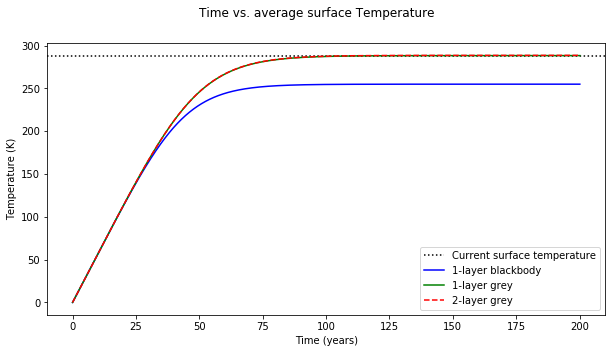

In [4]:
# Test the models to be sure they work!
# Start from 0K and see how temperature evolves in time for the different models

# 1-layer, black atmosphere
integratebb(0,dt,t_end,T_bb,time,C_earth)
# 1-layer, grey atmosphere
integrateatm(0,dt,t_end,T_1lay,time,C_earth)
# 2-layer, grey atmosphere
integrate2atm(0,dt,t_end,T_2lay,time,C_earth)

# Time vector for plots
tyr = [i/year for i in time]

# Plot surface temperature vs time
font = {'size'   : 20}

fig = plt.figure(figsize=(10,5))
plt.axhline(y=288.15, color='black', linestyle='dotted',label='Current surface temperature')
plt.plot(tyr,T_bb,label="1-layer blackbody",color='blue')
plt.plot(tyr,T_1lay,label="1-layer grey",color='green')
plt.plot(tyr,T_2lay,'r--',label="2-layer grey")
fig.suptitle('Time vs. average surface Temperature')
plt.xlabel('Time (years)')
plt.ylabel('Temperature (K)')
plt.legend()

The 1-layer and 2-layer model provide very similar results as we are using a really low emissivity for the upper layer.

**Step 3: use the time dependent model for a 2-layer grey atmosphere to determine how eps1 will change to match the RCP 8.5 future temperature**

The RCP 8.5 scenario assumes a 4deg increase in temperature by 2100, with an approximately linear temporal variation. We assume this variation occurs in 95 years (from 2005 to 2100).

In [5]:
# define function to let epsilon linearly vary in time
def eps_t(t,t_end):
    eps1_time=eps1_initial+(eps1_final-eps1_initial)*(t)/t_end
    return eps1_time

# define function to numerically integrate the model
# 2-layer, grey atmosphere, time-varying emisssivity for the lower layer (troposphere)
def integrate2atm_epst(T0, dt, end_time, T_list, t_list, eps_list,C):
    T,t = T0, 0
    T_list.clear(); T_list.append(T0)
    t_list.clear(); t_list.append(t)
    eps_list.clear(); eps_list.append(eps1_initial)

    # use Euler forward method to integrate Temperature over time
    while (t<=end_time):
        t = t  + dt
        #T = T  + (dt/C)*(A*S*(1-alpha) + (T**4)*B*( ( eps_t(t,t_end)*(1+0.5*eps2*(1-eps_t(t,t_end)))/(2-eps_t(t,t_end)*eps2*0.5) ) + ( (1-eps_t(t,t_end))*eps2*( 0.5*(1-eps_t(t,t_end)) + eps_t(t,t_end)*( (1+eps2*(1-eps_t(t,t_end))*0.5)/(2-eps_t(t,t_end)*eps2*0.5) ) ) ) - 1 ))
        T = T  + (dt/C)*(A*S*(1-alpha)*(1-alpha2) + (T**4)*B*( ( eps_t(t,t_end)*(1+0.5*eps2*(1-eps_t(t,t_end)))/(2-eps_t(t,t_end)*eps2*0.5) ) + ( (1-eps_t(t,t_end))*eps2*( 0.5*(1-eps_t(t,t_end)) + eps_t(t,t_end)*( (1+eps2*(1-eps_t(t,t_end))*0.5)/(2-eps_t(t,t_end)*eps2*0.5) ) ) ) - 1 ))
        T_list.append(T)
        t_list.append(t)
        eps_list.append(eps_t(t,t_end))
    return()

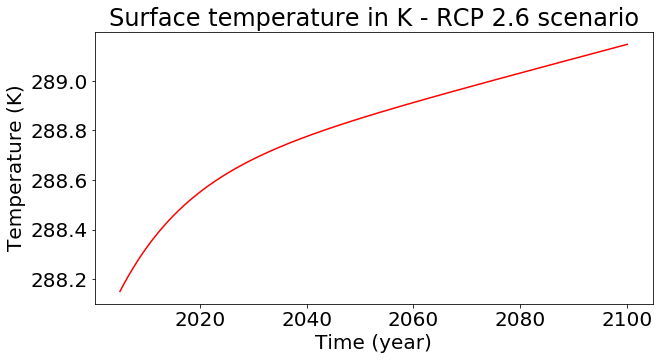

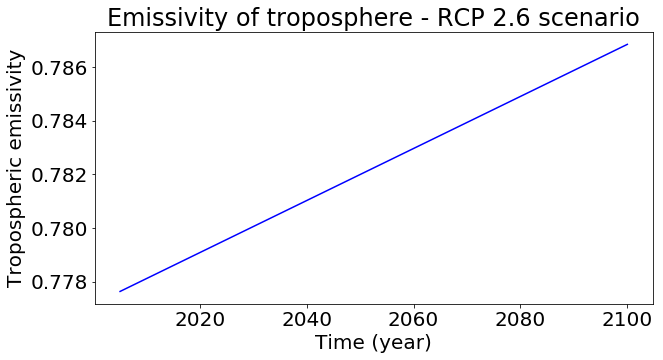

In [21]:
# How does the emissivity of the troposphere need to change in time to match the temperature of the RCP 8.5 scenario?

t_end = year*95 # from 2005 to 2100
T_end_RCP85 = 289.15 # temperature in 2100 according to the RCP 8.5 scenario

eps1_initial = float(eps1) # initial (2005) value for emissivity of the troposphere - use value found in step 1
eps1_final = eps1_initial # the final (2100) value will be found in a loop. Start assuming no change in emissivity, then increase it in the loop

T_RCP85 = [0] # list to store the time series of temperature in the RCP 8.5 scenario
# Note: we need to assign a value here just to make the loop work at the first iteration!

# Loop: increase the emissivity of the troposphere until the surface temperature in 2100 is really close to the prediction by the RCP 8.5 scenario
while abs(T_RCP85[-1]-T_end_RCP85) > 0.005: # 0.015K tolerance
    
    # clear lists to store outputs
    eps1_RCP85=[] # emissivity of troposphere
    T_RCP85=[] # temperature (K)
    time = [] # time
    
    # numerical integration
    integrate2atm_epst(T0=288.15, dt=dt, end_time=t_end, T_list= T_RCP85, t_list=time,eps_list=eps1_RCP85, C=C_earth)

    # increase the emissivity of the troposphere to keep the loop going until the "correct" value is found!
    eps1_final = eps1_final+0.0001

# Time vector for plots
tyr = [i/year+2005 for i in time]

# Time series of temperature according to the RCP 8.5 scenario
fig = plt.figure(figsize=(10,5))
plt.plot(tyr,T_RCP85,'r-')
plt.xlabel("Time (year)"); 
plt.ylabel("Temperature (K)")
plt.title("Surface temperature in K - RCP 2.6 scenario"); 
plt.rc('font', **font)

# Time series of tropospheric emissivity to match the RCP 8.5 scenario
fig = plt.figure(figsize=(10,5))
plt.plot(tyr,eps1_RCP85,'b-')
plt.xlabel("Time (year)"); 
plt.ylabel("Tropospheric emissivity")
plt.title("Emissivity of troposphere - RCP 2.6 scenario"); 
plt.rc('font', **font)

**Step 4: increase the albedo of the stratosphere in time to keep the surface temperature ~ constant in time**

This step is to model the injection of sulfate aerosols in the stratosphere. We assume that the main effect of the injection of sulfate aerosols in the stratosphere is a reduction in the incoming solar radiation due to an increase of albedo in the stratosphere.

We will try different functional forms for the change in time of the albedo.

In [7]:
# define function to numerically integrate the model
# 2-layer, grey atmosphere, time-varying emisssivity for the lower layer (troposphere), time varying albedo ("stratosphere")
def integrate2atm_epst_alphat(T0, dt, end_time, T_list, t_list, eps_list, alpha_list, C):
    T,t = T0, 0
    T_list.clear(); T_list.append(T0)
    t_list.clear(); t_list.append(t)
    eps_list.clear(); eps_list.append(eps1_initial)
    alpha_list.clear(); alpha_list.append(alpha_initial)

    # use Euler forward method to integrate Temperature over time
    while (t<=end_time):
        t = t  + dt
        #T = T  + (dt/C)*(A*S*(1-alpha_t(t,t_end)) + (T**4)*B*( (eps_t(t,t_end)*(1+0.5*eps2*(1-eps_t(t,t_end)))/(2-eps_t(t,t_end)*eps2*0.5) ) + ( (1-eps_t(t,t_end))*eps2*( 0.5*(1-eps_t(t,t_end)) + eps_t(t,t_end)*( (1+eps2*(1-eps_t(t,t_end))*0.5)/(2-eps_t(t,t_end)*eps2*0.5) ) ) ) - 1 ))
        T = T  + (dt/C)*(A*S*(1-alpha)*(1-alpha_t(t,t_end)) + (T**4)*B*( ( eps_t(t,t_end)*(1+0.5*eps2*(1-eps_t(t,t_end)))/(2-eps_t(t,t_end)*eps2*0.5) ) + ( (1-eps_t(t,t_end))*eps2*( 0.5*(1-eps_t(t,t_end)) + eps_t(t,t_end)*( (1+eps2*(1-eps_t(t,t_end))*0.5)/(2-eps_t(t,t_end)*eps2*0.5) ) ) ) - 1 ))
        
        T_list.append(T)
        t_list.append(t)
        alpha_list.append(alpha_t(t,t_end))
        eps_list.append(eps_t(t,t_end))
    return()

**4-A: assume linear change for the albedo**

In [8]:
# define function to let the albedo linearly vary in time
def alpha_t(t,t_end):
    m = (alpha_final - alpha_initial)/(t_end-0)
    b = alpha_initial
    a = m*t+b
    return a

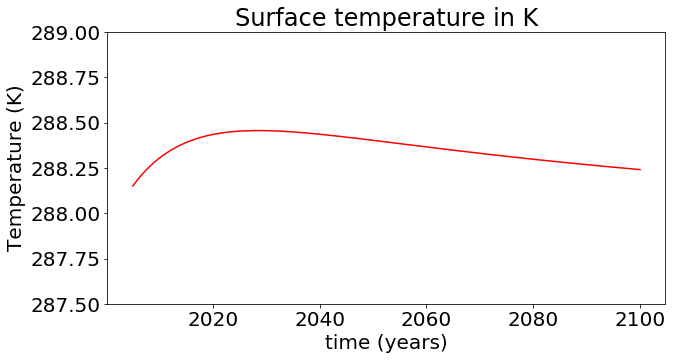

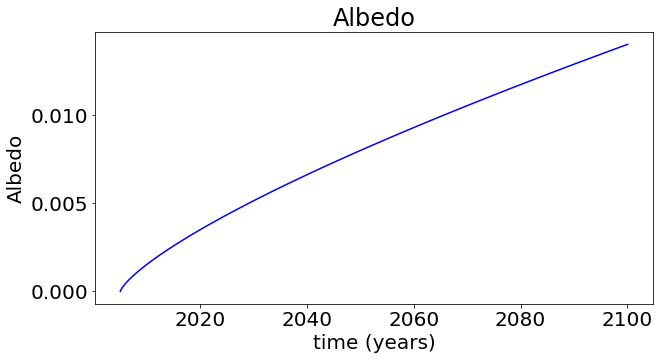

In [22]:
alpha_initial = alpha2 # initial (2005) value for albedo - use value used in the current state of climate
alpha_final = alpha_initial # final (2100) value for albedo - Start assuming no change in albedo, then increase it in the loop

T_RCP85_alphat = [0] # list to store the time series of temperature 
# Note: we need to assign a value here just to make the loop work at the first iteration!

# Loop until the final (2100) temperature is close to the initial (2015) one
while abs(T_RCP85_alphat[-1]-288.15) > 0.1:
    
    # clear lists to store outputs
    eps1_RCP85_alphat = [] # emissivity of troposphere
    T_RCP85_alphat = [] # temperature (K)
    alphat = [] # albedo
    time = [] # time

    # Numerical integration
    integrate2atm_epst_alphat(T0=288.15, dt=dt, end_time=t_end, T_list= T_RCP85_alphat, t_list=time, eps_list=eps1_RCP85_alphat, alpha_list = alphat, C=C_earth)

    # Increase albedo to keep the loop going
    alpha_final = alpha_final + 0.001

# Time vector for plots
tyr = [i/year+2005 for i in time]

# Time series of temperature
fig = plt.figure(figsize=(10,5))
plt.plot(tyr,T_RCP85_alphat,'r-')
plt.xlabel("time (years)"); plt.ylabel("Temperature (K)")
plt.title("Surface temperature in K"); 
plt.ylim([287.5,289])
plt.rc('font', **font)

# Time series of albedo
fig = plt.figure(figsize=(10,5))
plt.plot(tyr,alphat,'b-')
plt.xlabel("time (years)"); plt.ylabel("Albedo")
plt.title("Albedo"); 
plt.rc('font', **font)

**4-B: assume log change of albedo in time**

In [25]:
# define function to let the albedo vary in time with a logaritmic function
import math

def alpha_t(t,t_end):
    a = alpha_initial + (math.log(1+t/t_end*2,2))*(alpha_final - alpha_initial)
    return a

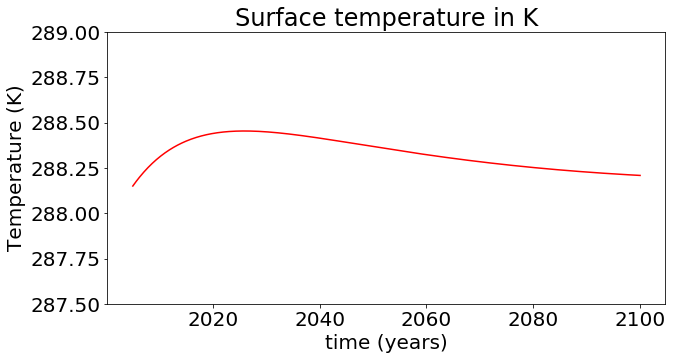

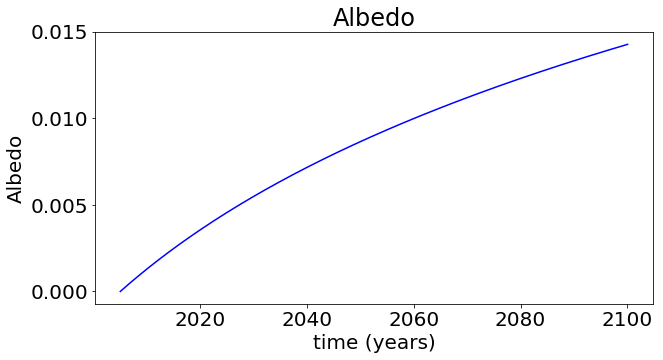

In [26]:
alpha_initial = alpha2 # initial (2005) value for albedo - use value used in the current state of climate
alpha_final = alpha_initial # final (2100) value for albedo - Start assuming no change in albedo, then increase it in the loop

T_RCP85_alphat = [0] # list to store the time series of temperature 
# Note: we need to assign a value here just to make the loop work at the first iteration!

# Loop until the final (2100) temperature is close to the initial (2015) one
while abs(T_RCP85_alphat[-1]-288.15) > 0.1:
    
    # clear lists to store outputs
    eps1_RCP85_alphat = [] # emissivity of troposphere
    T_RCP85_alphat = [] # temperature (K)
    alphat = [] # albedo
    time = [] # time

    # Numerical integration
    integrate2atm_epst_alphat(T0=288.15, dt=dt, end_time=t_end, T_list= T_RCP85_alphat, t_list=time, eps_list=eps1_RCP85_alphat, alpha_list = alphat, C=C_earth)

    # Increase albedo to keep the loop going
    alpha_final = alpha_final + 0.001

# Time vector for plots
tyr = [i/year+2005 for i in time]

# Time series of temperature
fig = plt.figure(figsize=(10,5))
plt.plot(tyr,T_RCP85_alphat,'r-')
plt.xlabel("time (years)"); plt.ylabel("Temperature (K)")
plt.title("Surface temperature in K"); 
plt.ylim([287.5,289])
plt.rc('font', **font)

# Time series of albedo
fig = plt.figure(figsize=(10,5))
plt.plot(tyr,alphat,'b-')
plt.xlabel("time (years)"); plt.ylabel("Albedo")
plt.title("Albedo"); 
plt.rc('font', **font)

**4-C: assume a power-law change of albedo with time**

In [27]:
# define function to let the albedo vary in time with a power-law function
def alpha_t(t,t_end):
    m = (alpha_final - alpha_initial)/(t_end-0)
    b = alpha_initial
    a = m*(t/t_end)**0.75*t_end+b
    return a

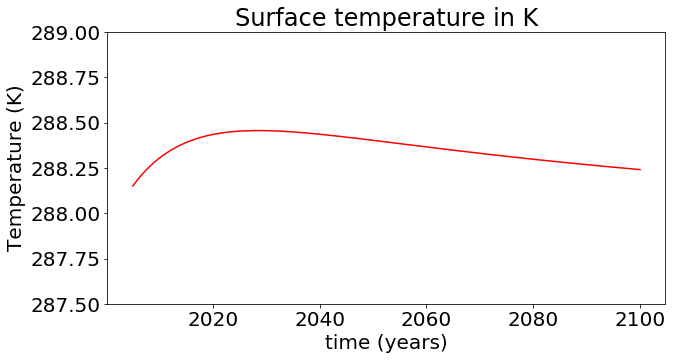

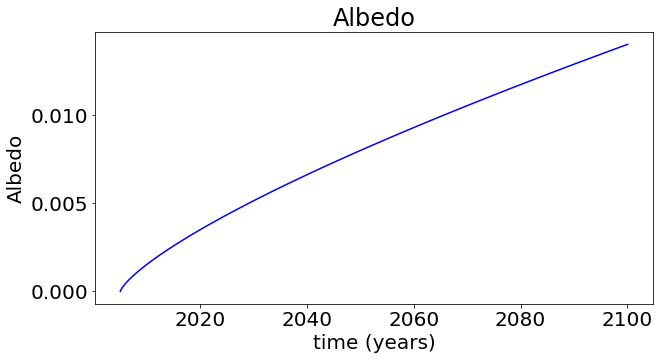

In [28]:
alpha_initial = alpha2 # initial (2005) value for albedo - use value used in the current state of climate
alpha_final = alpha_initial # final (2100) value for albedo - Start assuming no change in albedo, then increase it in the loop

T_RCP85_alphat = [0] # list to store the time series of temperature 
# Note: we need to assign a value here just to make the loop work at the first iteration!

# Loop until the final (2100) temperature is close to the initial (2015) one
while abs(T_RCP85_alphat[-1]-288.15) > 0.1:
    
    # clear lists to store outputs
    eps1_RCP85_alphat = [] # emissivity of troposphere
    T_RCP85_alphat = [] # temperature (K)
    alphat = [] # albedo
    time = [] # time

    # Numerical integration
    integrate2atm_epst_alphat(T0=288.15, dt=dt, end_time=t_end, T_list= T_RCP85_alphat, t_list=time, eps_list=eps1_RCP85_alphat, alpha_list = alphat, C=C_earth)

    # Increase albedo to keep the loop going
    alpha_final = alpha_final + 0.001

# Time vector for plots
tyr = [i/year+2005 for i in time]

# Time series of temperature
fig = plt.figure(figsize=(10,5))
plt.plot(tyr,T_RCP85_alphat,'r-')
plt.xlabel("time (years)"); plt.ylabel("Temperature (K)")
plt.title("Surface temperature in K"); 
plt.ylim([287.5,289])

# Time series of albedo
fig = plt.figure(figsize=(10,5))
plt.plot(tyr,alphat,'b-')
plt.xlabel("time (years)"); plt.ylabel("Albedo")
plt.title("Albedo"); 

The logaritmic case determines the lowest variability in surface temperature.

**Step 5: determine amount of sulfate aerosols needed to be injected each year.**

Here, we use the Beer-Lambert Law to determine how much sulfate will need to be injected into the stratosphere each year to maintain the stratospheric albedo specified above. We can find the mass density of the particles needed in a single column of the atmosphere to achieve the desired albedo, and then multiply across the volume of the stratosphere to get entire sulfate mass needed.

#### Assumptions

* Solar radiation is distributed evenly over the stratosphere.

* As the stratosphere is stably stratified, vertical mixing is suppressed. Therefore, we assume the aerosols will be distributed only at a range of specified depths, where the injection will likely take place. In detail, here we have assumed the aerosols are injected in the lower 8km of the stratosphere, with a constant tropopause height of 12km. The horizontal distribution is assumed to be homogeneous.

* The mass of sulfur is ~ 1/3 the mass of sulfate (Rasch, 2008b).

* Extinction via sulfate molecules ($SO_4^{-2}$) is solely via scattering (single scattering albedo of 1).

* The mass extinction coefficient ($\kappa_\lambda$) is constant over entire incoming shortwave range. Similarly, the albedo is constant over entire incoming shortwave range.

* We consider upper and lower bounds for the mass extinction coefficient in our calculations to take into account a range in particle sizes (from 0.32 - 1.19 $\mu$m) (Guo, 2013).

* Relative humidity of the stratosphere is 0, so there is no hydrophilic growth of the aerosols.

* Tg output is of Sulfur only. Oxygen has an atomic mass of 16u and sulfur has an atomic mass of 32u.

* Sulfate aerosol particle lifetime in stratopshere is one year.



#### Beginning Equation (from Beer's Law):

$$1-\alpha_\lambda = t_\lambda = e^{-\int \kappa_\lambda \rho ds}$$

$\alpha_\lambda$ = albedo at a specific wavelength. As mentioned, we assume a constant albedo for the entire incoming solar radiation. The albedo value should be the final albedo of the stratosphere from our model.

$t_\lambda$ = transmittence at a specific wavelength. Again, we assume it to be constant for the entire incoming solar radiation.

$\kappa_\lambda$ = $\frac{m^2}{kg}$, mass extinction coefficient for sulfate.

$\rho$ = $\frac{kg}{m^3}$, mass density (what we want to know) 

$ds$ = $m$, optical path (lower 8 km of stratosphere, from 12 km to 20 km)

#### Integrate over Stratosphere depth...

$$1-\alpha_\lambda = e^{-\int_{12000 m}^{20000 m} \kappa_\lambda \rho ds}$$

#### Rearrange to find $\rho$...

$$\rho = \frac{ln(1-\alpha_\lambda)}{-8000 m * \kappa_\lambda \frac{m^2}{g}}$$

#### Find volume of air in Stratosphere 

(assumming stratosphere of constant depth and spherical earth of radius 6371 Km):

$$ V_s = 4\pi * \frac{{{(6371 km + 20 km)}^3}-{(6371 km + 12 km)}^3}{3} $$

#### Solve for Teragrams Sulfate

$$Tg_{sulfate} = \frac{V_s {m^3} * \rho \frac{g}{m^3}}{1*10^{12} \frac{grams}{Tg}}$$

#### Solve for Teragrams Sulfur

$$Tg_{sulfur} = \frac{Tg_{sulfate}}{3}$$


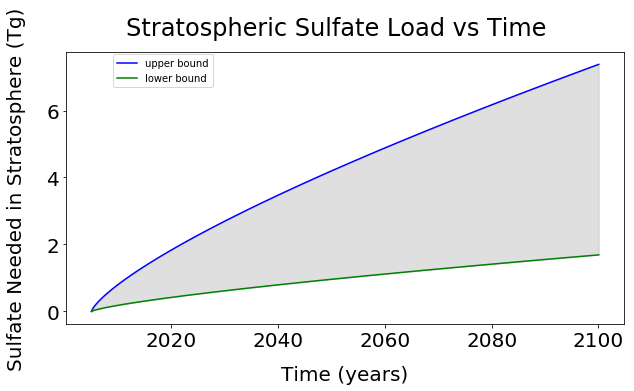

In [29]:
spray_top = 20E3 # top level of the stratosphere where we assume aerosols are present (m)
spray_bot = 12E3 # bottom level of the stratosphere where we assume aerosols are present (m)
ds = spray_top-spray_bot # active depth of stratosphere, m
K1 = 0.98 # mass extinction coefficient, lower bound (m2/kg)
K2 = 4.28 #mass extinction coefficient, upper bound (m2/kg)
Re = 6371E3 # radius of Earth

# function to calculate amount of aerosol needed to have a given value for the albedo
def s_calc(end_time,dt,t_list,K,alpha,st,sb,ds,tgS):
    tgS0,t,i = 0, 0, 0
    tgS.clear(); tgS.append(tgS0)
    t_list.clear(); t_list.append(t)

    while(t<=end_time):
        t = t + dt
        i = i + 1

        rho = -np.log(1-alpha[i])/(K*ds)
        vol_strat = 4*np.pi*((Re+st)**3-(Re+sb)**3)
        total_kg = rho*vol_strat/1000
        total_tg = total_kg*10**-9
        
        tgS.append(total_tg/3.) 
        t_list.append(t)
    return()
dt = 5*1e6 # s
tend = year*95 # 95 years in the model

# Lists to store results
time = []
tgS_upper,tgS_lower = [],[]

# Calculate amount of sulfate - upper limit for K
s_calc(tend,dt,time,K1,alphat,spray_top,spray_bot,ds,tgS_upper)
# Calculate amount of sulfate - lower limit for K
s_calc(tend,dt,time,K2,alphat,spray_top,spray_bot,ds,tgS_lower)

# Time vector for plots
tyr = [i/year+2005 for i in time]

# Plot: how much aerosols need to be in the stratosphere at any given time in the future?
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.set_xlabel('Time (years)',labelpad=15)
ax1.set_ylabel('Sulfate Needed in Stratosphere (Tg)',labelpad=20)
ax1.plot(tyr,tgS_upper,label="upper bound",color='blue')
ax1.plot(tyr,tgS_lower,label="lower bound",color='green')
ax1.fill_between(tyr,tgS_lower,tgS_upper,color='gray',alpha=0.25)
#ax2 = ax1.twinx()
#ax2.set_ylabel('Surface Temperature (K)',rotation='270',labelpad=50)
#ax2.plot(tyr,T_RCP85_alphat,label="Surface Temperature Desired",color='red', linestyle='--')
#ax2.set_ylim((287,290))
fig.suptitle('Stratospheric Sulfate Load vs Time')
fig.legend(loc=2,bbox_to_anchor=(0.15,0.95),prop={'size': 10})

In [30]:
# Assuming a 1 year lifetime for the aerosol, determine the total load required over the course of the considered 95 years
# and the average load per year

ts = year/dt
# To store results (upper and lower bound)
S_by_year_upper = [0]*96
S_by_year_lower = [0]*96

# Simple (as we're assuming a 1-year lifetime) integration of the plot above
for i in range(0,96):
    index = int(round(i*ts))
    
    S_by_year_upper[i] = tgS_upper[index]
    S_by_year_lower[i] = tgS_lower[index]

# Total load
S_total_upper = round(sum(S_by_year_upper),1)
S_total_lower = round(sum(S_by_year_lower),1)
# Average load per year
S_avg_upper = round(np.average(S_by_year_upper),2)
S_avg_lower = round(np.average(S_by_year_lower),2)

print("Total S load, upper bound scenario:",S_total_upper,"Tg")
print("Total S load, lower bound scenario:",S_total_lower,"Tg")
print("Average S load per year, upper bound scenario:",S_avg_upper,"Tg")
print("Average S load per year, lower bound scenario:",S_avg_lower,"Tg")

Total S load, upper bound scenario: 403.2 Tg
Total S load, lower bound scenario: 92.3 Tg
Average S load per year, upper bound scenario: 4.2 Tg
Average S load per year, lower bound scenario: 0.96 Tg


#### Comparison to Volcano

The largest single day total SO$_2$ loading by a volcano observable by satellite was around 10 TgS as observed by 
was Pinatubo on 15 June 1991 as reported in Carn et al. 2016. According to NASA's Earth Observatory, Pinatubo reduced Earth's temperature by around .6ºC over the next 15 months on average.

#### Comparison to Other Findings

Rasch et al. conducted a nice review of sulfate geoengineering studies up through 2008. They present findings stating that anywhere between 1.5 and 5 TgS/yr would be needed to combat the anthropogenic warming associated with doubling the current CO$_2$ in the atmosphere. In contrast, we found that on average, anywhere between 4 and 18 TgS/yr would be needed. This can be explained by several key assumptions we made in our simulations. First, we consider offsetting the effects of nearly quadrupling CO$_2$, instead of just doubling it. Second, the Rasch study considered a large spectrum of particles, up to over 2 $\mu$m in radius, where as we considered a homogenous dispersal of same-sized aerosols. Additionally, we used a simple single column model, while most of these studies have been conducted using full global models. The review paper studies inject aerosols from 15-25 km in the vertical; we considered aerosol injection from 12-20 km. Our residence time is approximate (and convenient for this study), and assumes that all particles injected at any one time exit the stratosphere together. Realistically, they should vary depending on particle size and vertical location in the stratosphere. This simplification, too, may have contributed to differing findings. Finally, we took our mass extinction coefficient values from a the Takemura (2002) study; the coefficients used by Rasch et al. may also have been different.

#### References

Carn, S.A., Clarisse, L. and Prata, A.J., 2016. Multi-decadal satellite measurements of global volcanic degassing. Journal of Volcanology and Geothermal Research, 311, pp.99-134.
    
Guo, L., Highwood, E. J., Shaffrey, L. C., and Turner, A. G.: The effect of regional changes in anthropogenic aerosols on rainfall of the East Asian Summer Monsoon, Atmos. Chem. Phys., 13, 1521-1534, https://doi.org/10.5194/acp-13-1521-2013, 2013.
    
Rasch, P., P. Crutzen, and D. Coleman, 2008: Exploring the geoengineering of climate using stratospheric sulfate aerosols: The role of particle size. Geophysical Research Letters, v.35 (2008), 35, doi:10.1029/2007GL032179.
    
Rasch, Philip J., et al. "An overview of geoengineering of climate using stratospheric sulphate aerosols." Philosophical Transactions of the Royal Society of London A: Mathematical, Physical and Engineering Sciences 366.1882 (2008): 4007-4037.

Takemura, Toshihiko, et al. "Single-scattering albedo and radiative forcing of various aerosol species with a global three-dimensional model." Journal of Climate 15.4 (2002): 333-352.

https://earthobservatory.nasa.gov/IOTD/view.php?id=1510

**Step 6: turn off the geoengineering solution (i.e. the variation of albedo with time), and monitor the rebound effect.**

We turn off the change in stratospheric albedo at a given time, then we allow 1 years (average lifetime for sulfate aerosols in the stratosphere) for the albedo to go back to zero, and we keep it constant at zero for the remainder of the simulation time. We want to see how the surface temperature changes in this scenario.

In [31]:
# define function to numerically integrate the model
# 2-layer, grey atmosphere, time-varying emisssivity for the lower layer (troposphere), time varying albedo ("stratosphere")
def integrate2atm_epst_alphat2(T0, dt, end_time, T_list, t_list, eps_list, alpha_list, C):
    T,t = T0, 0
    T_list.clear(); T_list.append(T0)
    t_list.clear(); t_list.append(t)
    eps_list.clear(); eps_list.append(eps1_initial)
    alpha_list.clear(); alpha_list.append(alpha_initial)

    # use Euler forward method to integrate Temperature over time
    while (t<=end_time):
        t = t  + dt
        T = T  + (dt/C)*(A*S*(1-alpha)*(1-alpha_t2(t,t_end)) + (T**4)*B*( ( eps_t(t,t_end)*(1+0.5*eps2*(1-eps_t(t,t_end)))/(2-eps_t(t,t_end)*eps2*0.5) ) + ( (1-eps_t(t,t_end))*eps2*( 0.5*(1-eps_t(t,t_end)) + eps_t(t,t_end)*( (1+eps2*(1-eps_t(t,t_end))*0.5)/(2-eps_t(t,t_end)*eps2*0.5) ) ) ) - 1 ))
        
        T_list.append(T)
        t_list.append(t)
        alpha_list.append(alpha_t2(t,t_end))
        eps_list.append(eps_t(t,t_end))
    return()

# define function to let the albedo vary in time with a logaritmic function - and stop at a given point
def alpha_t2(t,t_end):
    if t < t_end/4:
        # Phase 1: aerosol injection - albedo increases
        m = (alpha_final - alpha_initial)/(t_end-0)
        b = alpha_initial
        a = m*(t/t_end)**0.75*t_end+b
    elif t < t_end/4 + year:
        # Phase 2: aerosol injection stops - for 2 years (lifetime of sulfate aerosols in the stratosphere) linear decrease of albedo
        m = (alpha_final - alpha_initial)/(t_end-0)
        b = alpha_initial
        a_end_phase1 = m*(t_end/4/t_end)**0.75*t_end+b
        a = a_end_phase1 + (0 - a_end_phase1)/(t_end/4 + year - t_end/4)*(t-t_end/4)
    else:
        # Phase 3: albedo constant at zero
        a = 0
    return a

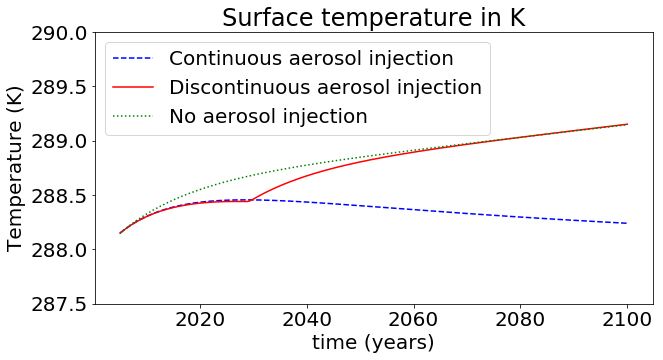

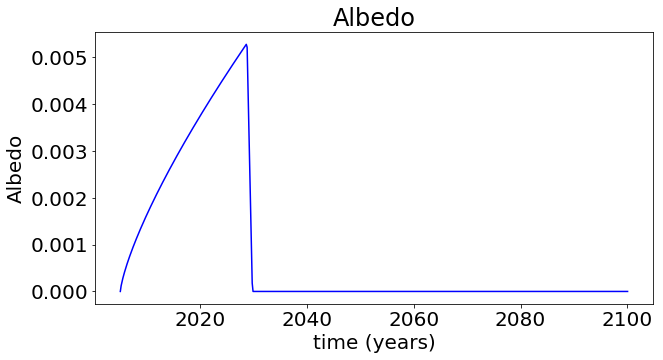

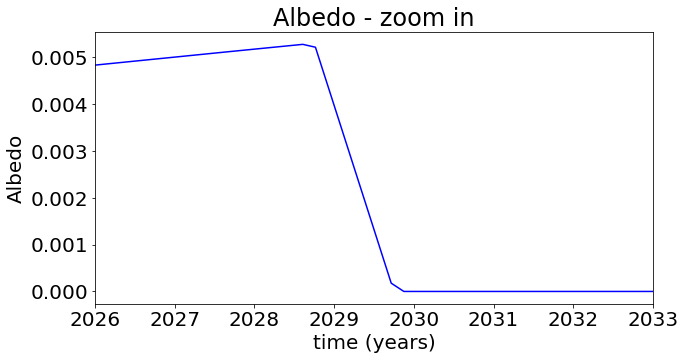

In [33]:
T_RCP85_alphat2 = [0] # list to store the time series of temperature 
# Note: we need to assign a value here just to make the loop work at the first iteration!

# clear lists to store outputs
eps1_RCP85_alphat2 = [] # emissivity of troposphere
T_RCP85_alphat2 = [] # temperature (K)
alphat2 = [] # albedo
time = [] # time

# Numerical integration
integrate2atm_epst_alphat2(T0=288.15, dt=dt, end_time=t_end, T_list= T_RCP85_alphat2, t_list=time, eps_list=eps1_RCP85_alphat2, alpha_list = alphat2, C=C_earth)

# Time vector for plots
tyr = [i/year+2005 for i in time]

# Time series of temperature
fig = plt.figure(figsize=(10,5))
plt.plot(tyr,T_RCP85_alphat,'b--',label="Continuous aerosol injection")
plt.plot(tyr,T_RCP85_alphat2,'r-',label="Discontinuous aerosol injection")
plt.plot(tyr,T_RCP85,'g:',label="No aerosol injection")
plt.xlabel("time (years)"); plt.ylabel("Temperature (K)")
plt.title("Surface temperature in K"); 
plt.ylim([287.5,290])
plt.legend()
plt.rc('font', **font)

# Time series of albedo
fig = plt.figure(figsize=(10,5))
plt.plot(tyr,alphat2,'b-')
plt.xlabel("time (years)"); plt.ylabel("Albedo")
plt.title("Albedo"); 
plt.rc('font', **font)

# Time series of albedo - zoom in
fig = plt.figure(figsize=(10,5))
plt.plot(tyr,alphat2,'b-')
plt.xlabel("time (years)"); plt.ylabel("Albedo")
plt.title("Albedo - zoom in"); 
plt.xlim([2026,2033])
plt.xticks(np.arange(2026, 2034, 1.0))
plt.rc('font', **font)